Using TensorFlow backend.


loading model...
Instructions for updating:
Colocations handled automatically by placer.
loading data...
102
Instructions for updating:
Use tf.cast instead.


<IPython.core.display.Javascript object>


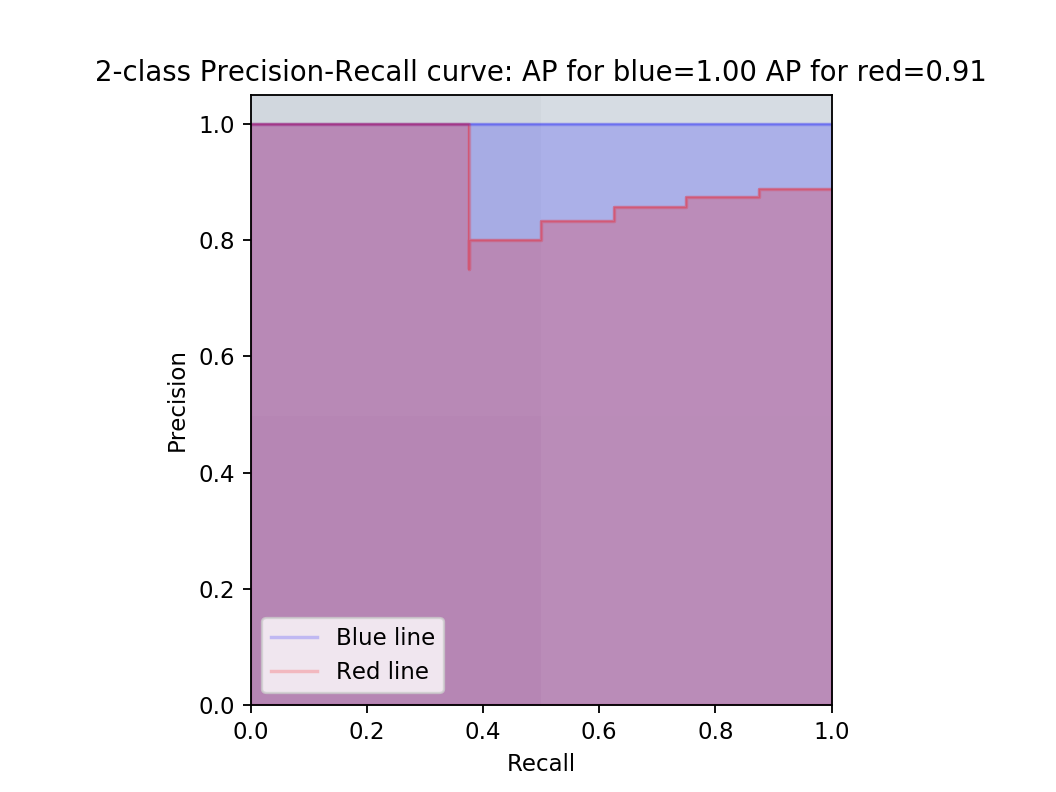

0.9067956349206349
Mean squared Error: 0.01892375190654525


In [1]:
%matplotlib notebook
import os
import numpy as np
import cv2
import imgaug as ia
import keras.backend as K
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import KeypointsOnImage
from sklearn.utils import class_weight
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Sequential,Model
from keras.layers import ReLU, Dense, Conv2D, Flatten,Dropout, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU, Activation, BatchNormalization, Input, merge, Softmax
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import random
from keras.constraints import max_norm
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature
from sklearn.metrics import average_precision_score,mean_squared_error
from keras.applications.inception_v3 import InceptionV3,preprocess_input




font = cv2.FONT_HERSHEY_SIMPLEX

def loadData(noBatchSamples,batchIdx,testData="test_data.txt",rootPathCentreLabel="./obj/labels",rootPathCroppedImages = "./obj/images"):
    """This function loads data from the directory of labels, it works with the yolo data format.
        
        Args:

            noBatchSamples (int) : Number of samples per batch
            batchIdx (int) : Batch number
            duplicativeFactor (int) : Number of times to oversample rare date
            rareData (str) : Filenames of rare data samples
            rootPathCentreLabel (str) : Directory with labels in yolo format
            rootPathCroppedImages (str) : Directory with images, image name and label name should be same eg: 1.jpg 1.txt
        
        Returns:
            list: Images in list 
            list: Targets 
            list: File names

    """
    
    y_train=[]
    X_train=[]
    name=[]
    f = open(testData)
    lines = f.readlines()
    lines = [x.strip() for x in lines]
    f.close()
    for ind,element in enumerate(os.listdir(rootPathCentreLabel)):
        if  ind >= noBatchSamples*batchIdx and ind<=noBatchSamples*(batchIdx+1):
            with open(os.path.join(rootPathCentreLabel,element)) as fin:
                y = [(0,0),(0,0)]
#                 print(os.path.join(rootPathCroppedImages,element.replace(".txt",".jpg")))
                img = cv2.imread(os.path.join(rootPathCroppedImages,element.replace(".txt",".jpg")),cv2.IMREAD_COLOR)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                for line in fin:
                    line=line.split(" ")
                    if line[0]=="0" :
                        pixel_y_pos =int(float(line[2]))
                        y[0]=(int(float(line[1])*100),int(float(line[2])*2000))
                    elif line[0]=="1" :
                        pixel_y_pos =int(float(line[2]))
                        if float(line[2])<1:
                            y[1]=(int(float(line[1])*100),int(float(line[2])*2000))
                    elif line[0]=="2" :
                        pixel_y_pos =int(float(line[2]))
                        if float(line[2])<1:
                            y[1]=(int(float(line[1])*100),int(float(line[2])*2000))
            if element in lines:
                y_train.append(y)
                X_train.append(img)
                name.append(element)
            else:
                pass
    combined = list(zip(X_train, y_train,name))
    random.Random(23).shuffle(combined)

    X_train[:], y_train[:],name[:] = zip(*combined)
    X_train=np.array(X_train)  
    print(len(X_train))
    return X_train,y_train,name #np.zeros((128, 32, 32, 3), dtype=np.uint8) + (batch_idx % 255)


def key2Target(keypoints,name):
    """This function converts keypoints returned after data augmentation to numpy arrays.
        
        Args:

            keypoints (imgaug.augmentables.kps.KeypointsOnImage) : Keypoints on the image
            name (list) : File names
        
        Returns:
            list: Images in list 
            list: Targets 
            list: File names

    """
    numred=0
    y_test_regression=[]
    y_test_categorical = []
    for i,k in enumerate(keypoints):
        y=np.zeros((2))
        y_class=np.zeros((2))
        
        if k[0][1]<=700 and (k[1][1]<=700 or k[1][1]>=1800): # Red line:False && Blue line:False
            y[0]=0
            y[1]=0
            y_class[0]=0
            y_class[1]=0
        
        elif k[0][1]>=700 and (k[1][1]<=700 or k[1][1]>=1800): # Red line:False && Blue line:True
            y[0]=k[0][1]/2000
            y[1]=0
            y_class[0]=1
            y_class[1]=0
        elif (k[1][1]>=700 and k[1][1]<=1900) and k[0][1]>=700: # Red line:True && Blue line:True
            numred+=1
            y[0]=k[0][1]/2000
            y[1]=k[1][1]/2000
            y_class[0]=1
            y_class[1]=1
        y_test_regression.append(np.array(y))
        y_test_categorical.append(np.array(y_class))
    return np.array(y_test_regression),np.array(y_test_categorical)


def returnAugmentationObj(percentageOfChance=0.):
    """This function returns an augementation pipeline which can be used to augment training data.
        
        Args:
            percentageOfChance (float) : Percentage of chance , eg: if it is 0.5, 50% of the images will go through the pipeline
        
        Returns:
            :class:`imgaug.augmenters.meta.Sequential` : Image augmentor 

    """

    sometimes = lambda aug: iaa.Sometimes(percentageOfChance, aug)

    # Define our sequence of augmentation steps that will be applied to every image
    # All augmenters with per_channel=0.5 will sample one value _per image_
    # in 50% of all cases. In all other cases they will sample new values
    # _per channel_.
    seq = iaa.Sequential(
        [
            sometimes(iaa.Affine(
                translate_percent={"x": (-0.05, 0.05), "y": (-0.03, 0.03)} # translate by -x to +x percent (per axis)
            ))
           
        ])
    return seq


def lossReg(y_true,y_pred):
    """Custom loss function to penalize A type virus versus B type written for keras.
    """
    mask=K.ones_like(y_true)
    l=K.square(y_pred-y_true)
    penalty = tf.constant([10.0])
    mask =tf.add(penalty,tf.to_float (tf.math.logical_or(tf.math.logical_and(tf.math.greater(y_true[:,0],y_true[:,1]),tf.math.less(y_pred[:,0],y_pred[:,1])),tf.math.logical_and(tf.math.less(y_true[:,0],y_true[:,1]),tf.math.greater(y_pred[:,0],y_pred[:,1])))))
    mask = tf.stack([K.ones_like(y_true[:,0]),mask],axis=1)
    return K.mean(tf.math.multiply(l,mask),axis=-1)


def returnModel(loadWeights,weightsFile="./red_blue_cust.hdf5"):
    """This function returns a keras model.
        
        Args:
            loadWeights (bool) : Load weights specified in the weightsFile param
            weightsFile (str) : Path to weights
        
        Returns:
            :class:`keras.model.Model` : Neural Network 

    """
    x = Input(shape=(500, 100,3))

    conv1=Conv2D(8, (3,3), padding='valid')(x)
    batchnorm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batchnorm1)
    

    conv2=Conv2D(8, (3,3), padding='valid')(act1)
    batchnorm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batchnorm2)
    maxpool2 = MaxPooling2D((2,2))(act2)

    conv3=Conv2D(16, (3,3), padding='valid')(maxpool2)
    batchnorm3 = BatchNormalization()(conv3)
    act3 = ReLU()(batchnorm3)

    conv4=Conv2D(16, (3,3), padding='valid')(act3)
    batchnorm4 = BatchNormalization()(conv4)
    act4 = ReLU()(batchnorm4)
    maxpool3 = MaxPooling2D((2,2))(act4)

    flat1 = Flatten()(maxpool3)
    D1 = Dense(256)(flat1)
    batchnorm5 = BatchNormalization()(D1)
    act5 = ReLU()(batchnorm5)

    D2 = Dense(128,kernel_constraint=max_norm(2))(act5)
    batchnorm6 = BatchNormalization()(D2)
    act6 = ReLU()(batchnorm6)


    D_soft = Dense(2)(act6)
    batchnorm7 = BatchNormalization()(D_soft)
    out1 = Activation('sigmoid',name="cat_kash")(batchnorm7)

    D_sigmoid = Dense(2)(act6)
    batchnorm8 = BatchNormalization()(D_sigmoid)
    out2 = Activation('sigmoid',name="reg_kash")(batchnorm8)

    model = Model(inputs=x, outputs=[out1,out2])
    if (loadWeights):
        model.load_weights(weightsFile,by_name=True)


    return model

    

def modelTransferLearning(loadWeights,weightsFile="./red_blue_transf.hdf5"):
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    D1 = Dense(256)(x)
    batchnorm5 = BatchNormalization()(D1)
    act5 = ReLU()(batchnorm5)
    D2 = Dense(128)(act5)
    batchnorm6 = BatchNormalization()(D2)
    act6 = ReLU()(batchnorm6) 
    D_soft = Dense(2)(act6)
    batchnorm7 = BatchNormalization()(D_soft)
    out1 = Activation('sigmoid',name="cat_kash")(batchnorm7)

    D_sigmoid = Dense(2)(act6)
    batchnorm8 = BatchNormalization()(D_sigmoid)
    out2 = Activation('sigmoid',name="reg_kash")(batchnorm8)

    model = Model(inputs=base_model.input, outputs=[out1,out2])
    for layer in model.layers[:249]:
       layer.trainable = False
    for layer in model.layers[249:]:
       layer.trainable = True
#     model.summary()
    if (loadWeights):
        model.load_weights(weightsFile,by_name=True)
    return model


config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 4} ) # Correctly put number of GPU and CPU
sess = tf.Session(config=config) 
with sess:
    useTransferLearning = False
    SeqAug = returnAugmentationObj()
    print("loading model...")
    if useTransferLearning:
        model = modelTransferLearning(True,"red_blue_transf.hdf5")
    else:
        model = returnModel(True,"red_blue_cust.hdf5")

    filepath="weights-latest_model_YCrCb_test.hdf5" # Name and path of weights to save

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min') # Checkpoint call back to save best model on validation set

    lrd=ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='auto', min_delta=0.00001, cooldown=5, min_lr=0.00000000000000000001) # Callback to control learning rate on plateau condition 
    print("loading data...")
    X_train,y_train,names = loadData(650,0) # Load all data in one batch, 3 since sample data has only 3

#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0., random_state=42) # Split data into training and testing 

    callbacks_list = [checkpoint,lrd]

    optimizer = Adam(lr=0.0009, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True) # Optimizer used to train

    model.compile(optimizer=optimizer, loss={"cat_kash":"binary_crossentropy","reg_kash":lossReg}, metrics={"cat_kash":'accuracy',"reg_kash":"mse"}) # Compile model for training
    K.set_learning_phase(0)


    xx_tr=[]
    yy_reg_tr=[]
    yy_cat_tr=[]
    images_aug_tr, keypoints_aug_tr = SeqAug(images=X_train,keypoints=y_train)  
    tar_train_reg,tar_train_cat=key2Target(keypoints_aug_tr,names)
    for ind,im in enumerate(images_aug_tr):
        im=im[1000:1500,:,:] # Crop out only test area
        if(useTransferLearning):
            xx_tr.append(preprocess_input(im))
        else:
            im = im/255.0
            im = np.array(im,dtype=np.float32)
            yuv_im = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)
            xx_tr.append(yuv_im)
    for ii in tar_train_reg:
        yy_reg_tr.append(ii)
    for ind,ii in enumerate(tar_train_cat):
        if False: # Set to true to save train images augmentated
            images_aug_tr[ind] = cv2.putText(images_aug_tr[ind],str(tar_train_cat[ind]),(0,20), font, 0.5,(255,0,0),2,cv2.LINE_AA)
            images_aug_tr[ind] = cv2.circle(images_aug_tr[ind],(50,int(keypoints_aug_tr[ind][0][1])),5, (0,0,255), 5)
            try:
                images_aug_tr[ind] = cv2.circle(images_aug_tr[ind],(50,int(keypoints_aug_tr[ind][1][1])),5, (255,0,0), 5)
            except:
                pass
            images_aug_tr[ind] = cv2.cvtColor(images_aug_tr[ind], cv2.COLOR_RGB2BGR)

            cv2.imwrite("./sample/train/"+str(ind)+".jpg",images_aug_tr[ind][1000:1500,:,:])
        yy_cat_tr.append(ii)
    xxx=np.array(xx_tr)
    yyy_reg=np.array(yy_reg_tr)
    yyy_cat=np.array(yy_cat_tr)
    predictions=model.predict(xxx)
    y_test = yyy_cat[:,0]
    y_score = predictions[0][:,0]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision1 = average_precision_score(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post',label="Blue line")
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    
    y_test = yyy_cat[:,1]
    y_score = predictions[0][:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    average_precision2 = average_precision_score(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='r', alpha=0.2,
             where='post',label="Red line")
    plt.fill_between(recall, precision, alpha=0.2, color='r', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    print(average_precision2)
    plt.title('2-class Precision-Recall curve: AP for blue={0:0.2f} AP for red={1:0.2f}'.format(
              average_precision1,average_precision2))
    plt.legend()
    print("Mean squared Error:",mean_squared_error(yyy_reg, predictions[1]))
    
    

In [ ]:
0.0189923
0.024536721439542924

In [ ]:
print(len(name),len(predictions[1]))

In [7]:
%matplotlib inline
ims_path="./obj/images"
label_path="./obj/labels"
label_path="./obj/labels"

for index,name in enumerate(names):
    basename = name.replace(".txt","")
    
    try:
        img_path = os.path.join(ims_path,basename+".jpg")
        img = cv2.imread(img_path)
        img[0]
    except:
        img_path = os.path.join(ims_path,basename+".jpeg")
        img = cv2.imread(img_path)
        img[0]
#     img = cv2.putText(images_aug_te[ind],str(tar_test_cat[ind]),(0,20), font, 0.5,(255,0,0),2,cv2.LINE_AA)
    if predictions[0][index,0]>0.5:
        img = cv2.circle(img,(50,int(predictions[1][index,0]*2000)),5, (255,0,0), 5)
    if predictions[0][index,1]>0.5:
        img = cv2.circle(img,(50,int(predictions[1][index,1]*2000)),5, (0,0,255), 5)
    cv2.imwrite("./sample/test/"+basename+".jpg",img)
    